# Mission 5 特征工程1
---


## 任务
关于数据类型转换以及缺失值处理（尝试不同的填充看效果）以及你能借鉴的数据探索


In [55]:
# 导入需要的包
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, classification_report

# 设置 pandas 显示列数
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 10000)

## 1. 导入数据

In [56]:
# 因为数据并非utf-8编码，要使用gbk编码读入，否则出错
data = pd.read_csv('./data/data.csv', index_col=0, encoding='gbk')

# 观察数据构成
# data.head()
print(data.shape)

(4754, 89)


In [134]:
# 划分 X, y
y = data['status']
X = data.drop('status', axis=1)

# X行数
print('X.shape:', X.shape)
print('y 的分布\n', y.value_counts())

X.shape: (4754, 88)
y 的分布
 0    3561
1    1193
Name: status, dtype: int64


## 2. 数据探索及特征处理
本次任务目的在于主流程，所以数据探索部分做得比较粗糙，以后有需要再慢慢补充
从上面数据看出，本份数据以数值型特征位数，有少数几个字符型特征，还有两个日期特征。下面一步步进行处理

### 删除无用变量

In [137]:
# 首先剔除一些明显无用的特征，如 id_name, custid, trade_no, bank_card_no，
# 这些优点类似一个人的唯一信息，如果加入模型训练且对最终模型生效的话，很可能就是出现了过拟合
X.drop(['id_name', 'custid', 'trade_no', 'bank_card_no'], axis=1, inplace=True)

# 下面代码用于删除数据中只有一个值的变量，或对每个用户取值均不同的变量
useless_col = []
for col in X.columns:
    if len(X[col].unique()) == 1 or len(X[col].unique()) >= X[col].count():
        useless_col.append(col)

X.drop(useless_col, axis=1, inplace=True)

### 数值型变量
取出数值型变量，观察缺失及分布情况

student_feature                     0.630627
cross_consume_count_last_1_month    0.089609
latest_three_month_apply            0.063946
query_finance_count                 0.063946
latest_six_month_apply              0.063946
latest_one_month_apply              0.063946
query_cash_count                    0.063946
query_sum_count                     0.063946
query_org_count                     0.063946
apply_credibility                   0.063946
dtype: float64


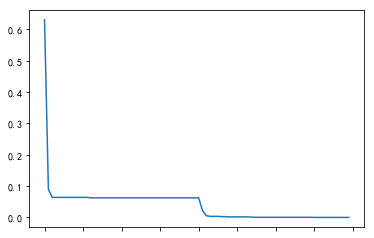

In [138]:
# 取出数值型变量
X_num = X.select_dtypes('number').copy()
# 查看缺失情况
num_miss_rate = 1 - X_num.count() / len(X_num)
num_miss_rate.sort_values(ascending=False, inplace=True)
print(num_miss_rate[:10])
num_miss_rate.plot()

D:\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
D:\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


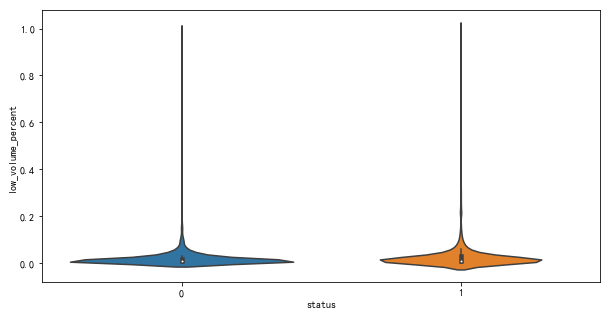

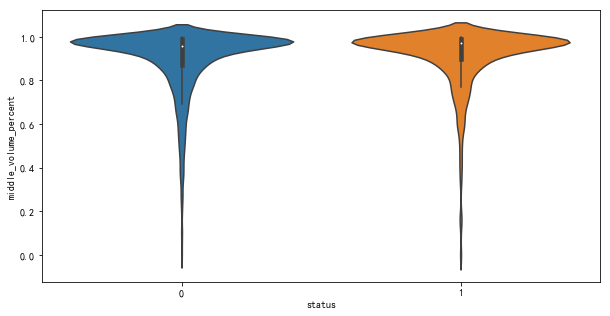

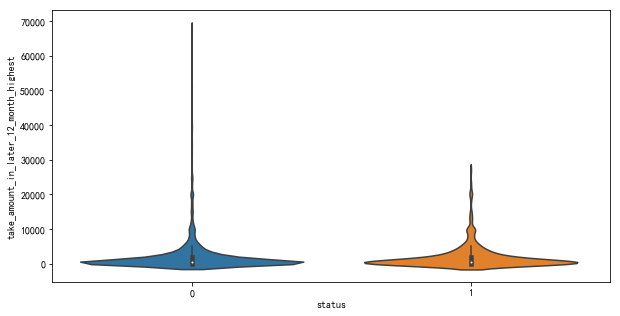

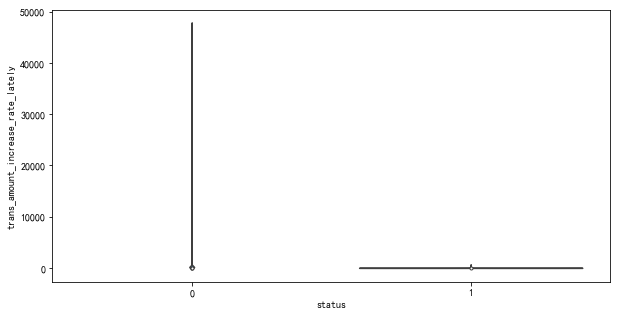

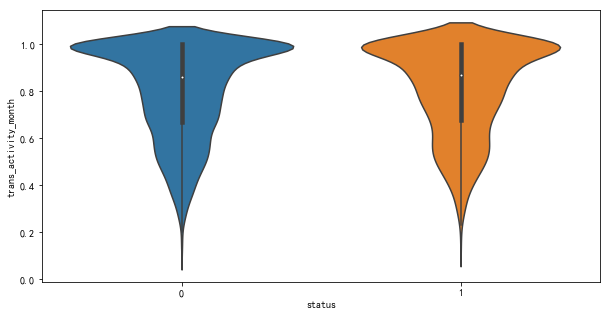

In [139]:
# 观察数据分布
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

for i, col in enumerate(X_num.columns[:5]):
    plt.figure(i + 1, figsize=(10, 5))
    # # 密度分布图
    # sns.distplot(X_num[col][y==1].dropna(), hist=True, kde=True)
    # sns.distplot(X_num[col][y==0].dropna(), hist=True, kde=True)
    # 分箱图
    #  sns.boxplot(y=X_num[col], x=y)
    # 小提琴图
    sns.violinplot(y=X_num[col], x=y)

**进行缺失值填充**

因为 student_feature 缺失值较多，使用0值填充；

对于其他变量，分别尝试使用 均值、中位数 填充

In [61]:
# student_feature
X_num.fillna({'student_feature': 0}, inplace=True)

# 其他数值型变量使用统计量填充
# X_num.fillna(X_num.mean(), inplace=True)  # 均值
X_num.fillna(X_num.median(), inplace=True)  # 中位数

**进行极端值处理**

由于在图像中发现大部分数据有极端值出现，偏离中心太远，可能会影响模型效果。

下面考虑使用 IQR方式 处理极端值

In [63]:
# 极端值处理函数
def iqr_outlier(x, thre=1.5):
    x_cl = x.copy()
    q25, q75 = x.quantile(q=[0.25, 0.75])
    iqr = q75 - q25
    top = q75 + thre * iqr
    bottom = q25 - thre * iqr

    x_cl[x_cl > top] = top
    x_cl[x_cl < bottom] = bottom

    return x_cl

# 对进行缺失值填充后的数据集进行极端值修正
X_num_cl = pd.DataFrame()
for col in X_num.columns:
    X_num_cl[col] = iqr_outlier(X_num[col])

X_num = X_num_cl

### 字符型变量
取出字符型变量，观察缺失及分布情况

In [67]:
# 字符型变量
X_str = X.select_dtypes(exclude='number').copy()
X_str.describe()

,reg_preference_for_trad,source,latest_query_time,loans_latest_time
count,4752,4754,4450,4457
unique,5,1,207,232
top,一线城市,xs,2018-04-14,2018-05-03
freq,3403,4754,423,134


由上面得出结论：
1. source只有一个值，无意义可剔除。
2. reg_preference_for_trad表示城市类型，仅有两个缺失，用众数填充后分别使用 哑变量 或 编码 的形式进行数据装换
3. latest_query_time，loans_latest_time 数据日期型，在下一步再进行操作

D:\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


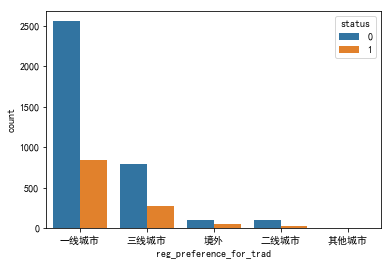

In [75]:
# 观察 reg_preference_for_trad 分布：
sns.countplot(X_str['reg_preference_for_trad'], hue=y)

In [77]:
# 众数填充
X_str['reg_preference_for_trad'] = X_str['reg_preference_for_trad'].fillna(X_str['reg_preference_for_trad'].mode()[0])

# 哑变量
X_str_dummy = pd.get_dummies(X_str['reg_preference_for_trad'])
# 数字编码
X_str_map = X_str['reg_preference_for_trad'].map({'一线城市': 0, '二线城市': 1,'三线城市': 2,  '其他城市': 3, '境外': 4})

### 日期/时间型变量
取出日期，可分别构建如 年、月、日、工作日、周数 等

如有时间，可分别构建如 小时、分钟 等

两两日期或时间可根据业务知识相互做差，求出相差天数，小时数等(此处先跳过)

In [116]:
X_date = pd.DataFrame()
X_date['latest_query_time_month'] = pd.to_datetime(X_str['latest_query_time']).dt.month  # 月份
X_date['latest_query_time_weekday'] = pd.to_datetime(X_str['latest_query_time']).dt.weekday  # 星期几

X_date['loans_latest_time_month'] = pd.to_datetime(X_str['loans_latest_time']).dt.month  # 月份
X_date['loans_latest_time_weekday'] = pd.to_datetime(X_str['loans_latest_time']).dt.weekday  # 星期几

X_date.fillna(X_date.median(), inplace=True)

### 合并各个变量

In [117]:
# 合并
X_cl = pd.concat([X_num, X_str_dummy, X_date], axis=1, sort=False)
X_cl.shape

(4754, 89)

### 3. 数据划分
三七 分，随机种子就取今天日期吧

In [118]:
random_state = 1115
X_train, X_test, y_train, y_test = train_test_split(X_cl, y, test_size=0.3, random_state=random_state)
print(X_train.shape)
print(X_test.shape)

(3327, 89)
(1427, 89)


In [119]:
# 数据归一化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

### 4. 建模
#### model1-LR

准确性：
Train：0.8019
Test：0.7975
召回率：
Train：0.3711
Test：0.3746
f1_score：
Train：0.4856
Test：0.4793
roc_auc：
Train：0.8053
Test：0.8063
KS：
Train：0.4475
Test：0.4775


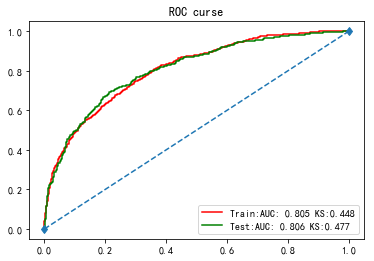

In [140]:
# 逻辑回归
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.05, penalty='l1')
lr.fit(X_train_std, y_train)

model_metrics(lr, X_train_std, X_test_std, y_train, y_test)

#### model2-svm

In [121]:
from sklearn.svm import SVC
# 线性 SVM
linear_svc = SVC(kernel='linear', probability=True)
linear_svc.fit(X_train_std, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [122]:
# 多项式 SVM
poly_svc = SVC(kernel='poly', probability=True)
poly_svc.fit(X_train_std, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### model3-决策树

In [123]:
from sklearn.tree import DecisionTreeClassifier
# 决策树
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(X_train_std, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### model4-XGBoost

**安装**

安装包路径：https://www.lfd.uci.edu/~gohlke/pythonlibs/#xgboost

找到合适的包，使用pip安装。如 pip install xgboost-0.81-cp27-cp27m-win_amd64.whl

**使用**

下面所说仅仅是普通调用，然而 XGB 有很多超参数需要调整，而且这些超参对结果会产生很大的影响，这次先不展开阐述。

参考：[XGBoost使用教程（纯xgboost方法）](https://blog.csdn.net/u011630575/article/details/79418138)

In [124]:
# xgbboost
from xgboost.sklearn import XGBClassifier
xgb_params = {
    'learning_rate': 0.1,
    'n_estimators': 42,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'nthread': 4,
    'scale_pos_weight': 1,
    'seed': 112
}
xgb_model = XGBClassifier(**xgb_params) # 迭代次数(n_estimators)已经是超参之一

# 训练
xgb_model.fit(X_train_std, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=42,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=112,
       silent=True, subsample=0.8)

#### model5-LightGBM

**安装**

使用 pip install lightgbm 直接安装

**使用**

这里的用法与xgb的非常类似

参考：[【集成学习】lightgbm使用案例](https://www.cnblogs.com/wanglei5205/p/8654041.html)

In [125]:
# lightgbm
from lightgbm.sklearn import LGBMClassifier
lgb_params  = {
    'learning_rate': 0.1,
    'n_estimators': 42,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary', # 这里和 xgb 不一样
    'nthread': 4,
    'scale_pos_weight': 1,
    'seed': 112
}
lgb_model = LGBMClassifier(**lgb_params) # 迭代次数(n_estimators)已经是超参之一

# 训练
lgb_model.fit(X_train_std, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        gamma=0, importance_type='split', learning_rate=0.1, max_depth=5,
        min_child_samples=20, min_child_weight=1, min_split_gain=0.0,
        n_estimators=42, n_jobs=-1, nthread=4, num_leaves=31,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, scale_pos_weight=1, seed=112, silent=True,
        subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

## 5. 评估

In [127]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve
from matplotlib import pyplot as plt
# 定义评估函数
def model_metrics(clf, X_train, X_test, y_train, y_test):
    # 预测
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    y_train_pred_proba = clf.predict_proba(X_train)[:, 1]
    y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

    # 评估
    # 准确性
    print('准确性：')
    print('Train：{:.4f}'.format(accuracy_score(y_train, y_train_pred)))
    print('Test：{:.4f}'.format(accuracy_score(y_test, y_test_pred)))

    # 召回率
    print('召回率：')
    print('Train：{:.4f}'.format(recall_score(y_train, y_train_pred)))
    print('Test：{:.4f}'.format(recall_score(y_test, y_test_pred)))
    
    # f1_score
    print('f1_score：')
    print('Train：{:.4f}'.format(f1_score(y_train, y_train_pred)))
    print('Test：{:.4f}'.format(f1_score(y_test, y_test_pred)))
    
    # roc_auc
    print('roc_auc：')
    print('Train：{:.4f}'.format(roc_auc_score(y_train, y_train_pred_proba)))
    print('Test：{:.4f}'.format(roc_auc_score(y_test, y_test_pred_proba)))    
    
    # 描绘 ROC 曲线
    fpr_tr, tpr_tr, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_te, tpr_te, _ = roc_curve(y_test, y_test_pred_proba)

    # KS
    print('KS：')
    print('Train：{:.4f}'.format(max(abs((fpr_tr - tpr_tr)))))
    print('Test：{:.4f}'.format(max(abs((fpr_te - tpr_te)))))

    # 绘图
    plt.plot(fpr_tr, tpr_tr, 'r-',
             label="Train:AUC: {:.3f} KS:{:.3f}".format(roc_auc_score(y_train, y_train_pred_proba), 
                                                        max(abs((fpr_tr - tpr_tr)))))
    plt.plot(fpr_te, tpr_te, 'g-',
             label="Test:AUC: {:.3f} KS:{:.3f}".format(roc_auc_score(y_test, y_test_pred_proba),
                                                     max(abs((fpr_te - tpr_te)))))
    plt.plot([0, 1], [0, 1], 'd--')
    plt.legend(loc='best')
    plt.title("ROC curse")
    plt.show()

准确性：
Train：0.8019
Test：0.7975
召回率：
Train：0.3711
Test：0.3746
f1_score：
Train：0.4856
Test：0.4793
roc_auc：
Train：0.8054
Test：0.8064
KS：
Train：0.4475
Test：0.4775


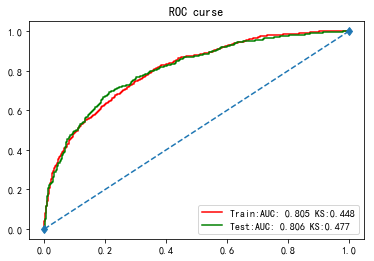

In [128]:
# 逻辑回归
model_metrics(lr, X_train_std, X_test_std, y_train, y_test)

准确性：
Train：0.8025
Test：0.8003
召回率：
Train：0.3628
Test：0.3718
f1_score：
Train：0.4806
Test：0.4809
roc_auc：
Train：0.8116
Test：0.7948
KS：
Train：0.4832
Test：0.4579


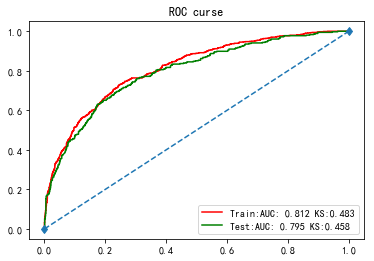

In [129]:
# 线性 SVM
model_metrics(linear_svc, X_train_std, X_test_std, y_train, y_test)

准确性：
Train：0.8659
Test：0.7786
召回率：
Train：0.4737
Test：0.2310
f1_score：
Train：0.6403
Test：0.3417
roc_auc：
Train：0.9797
Test：0.7461
KS：
Train：0.8827
Test：0.3721


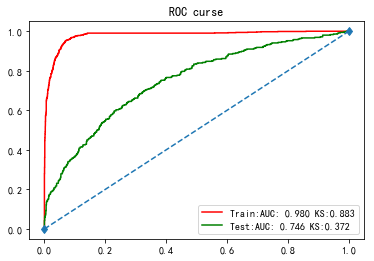

In [130]:
# 多项式 SVM
model_metrics(poly_svc, X_train_std, X_test_std, y_train, y_test)

准确性：
Train：0.8783
Test：0.7393
召回率：
Train：0.6587
Test：0.3662
f1_score：
Train：0.7316
Test：0.4114
roc_auc：
Train：0.9131
Test：0.6577
KS：
Train：0.6604
Test：0.2896


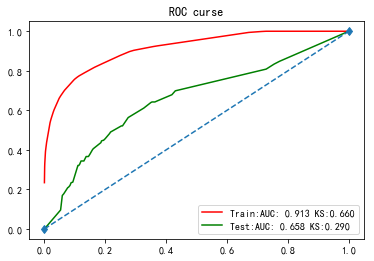

In [131]:
# 决策树
model_metrics(dt, X_train_std, X_test_std, y_train, y_test)

准确性：
Train：0.8822
Test：0.7989
召回率：
Train：0.5764
Test：0.3718
f1_score：
Train：0.7113
Test：0.4791
roc_auc：
Train：0.9520
Test：0.8026
KS：
Train：0.7703
Test：0.4738


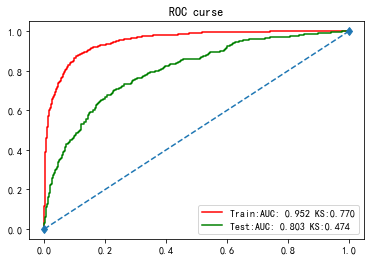

In [132]:
# xgboost
model_metrics(xgb_model, X_train_std, X_test_std, y_train, y_test)

准确性：
Train：0.8867
Test：0.7919
召回率：
Train：0.5859
Test：0.3577
f1_score：
Train：0.7226
Test：0.4610
roc_auc：
Train：0.9560
Test：0.7945
KS：
Train：0.7699
Test：0.4516


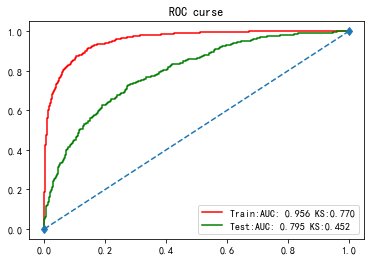

In [133]:
# lightgbm
model_metrics(lgb_model, X_train_std, X_test_std, y_train, y_test)